In [1]:
using Gen
using Flux
using JLD
using Random
using StatsBase
using LinearAlgebra
using PyPlot
using Distributions

include("LoadData.jl")
include("NUTS.jl")
include("utils.jl");

In [2]:
#Load Boston Housing Data
dx, dy, x_train, x_test, y_train, y_test = load_data(10);

In [3]:
#Bayesian Linear Regression

function G(x,trace)
    
    Wₒ = reshape(trace[:W], 1, 13)
    bₒ = trace[:b]
    
    nn_out = Dense(Wₒ, bₒ)
    return nn_out(x)
    
end;

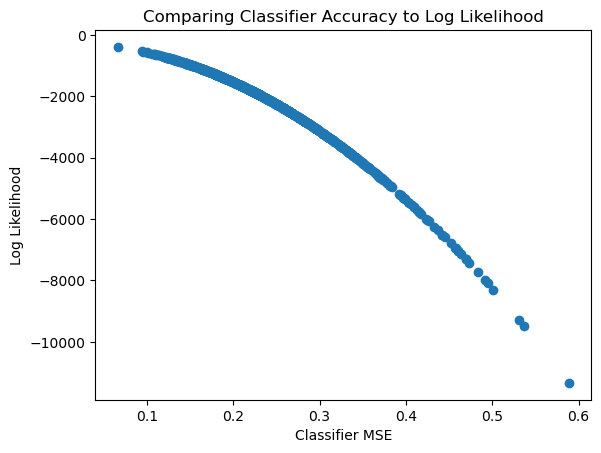

Best noise variance: 2.7997400824318897
Best MSE: 0.6092602775313936
Best Score: -389.09719689419825


In [19]:
#Probabilistic Model

@gen function interpolator(x)
    
    #Create a blank choicemap
    obs = choicemap()::ChoiceMap
    
    #Standard Deviations
    #τᵧ ~ gamma(100,0.2) #(100,0.5)
    #τᵧ ~ gamma(1,1)
    #σᵧ = 1/(τᵧ)
    
    #Sample weight and bias vectors
    u = zeros(13)
    S = Diagonal([1 for i=1:length(u)])
    W = @trace(mvnormal(u,S), :W)
    ub = zeros(1)
    Sb = Diagonal([1 for i=1:length(ub)])
    b = @trace(mvnormal(ub,Sb), :b)

    obs[:W] = W
    obs[:b] = b
    
    #Return Network Scores for X
    scores = transpose(G(x,obs))[:,1]
    #println(scores)
    
    #Regression Likelihood
    #y = @trace(mvnormal(vec(scores), Diagonal([σᵧ for i=1:length(x[1,:])])), (:y))
    y = @trace(mvnormal(vec(scores), Diagonal([1.0 for i=1:length(x[1,:])])), (:y))

    return scores
    
end

obs_master = choicemap()::ChoiceMap
obs_master[:y] = y_train
obs = obs_master;
(trace,) = generate(interpolator, (x_train,), obs)


#----------------
#Test Likelihood
#----------------
best_trace, scores, mses = likelihood_regression(x_train, y_train, 1000)
PyPlot.scatter(mses, scores)
plt.title("Comparing Classifier Accuracy to Log Likelihood")
plt.xlabel("Classifier MSE")
plt.ylabel("Log Likelihood")

pred_y = transpose(G(x_train,best_trace))[:,1]
best_mse = mse_scaled(pred_y, y_train)
variance = 1/(best_trace[:τᵧ])
println("Best noise variance: $variance")
println("Best MSE: $best_mse")
println("Best Score: $(get_score(best_trace))")

[NUTS] start sampling for 301 samples with inital ϵ=1
............................................................................................................................................................................................................................................................................................................

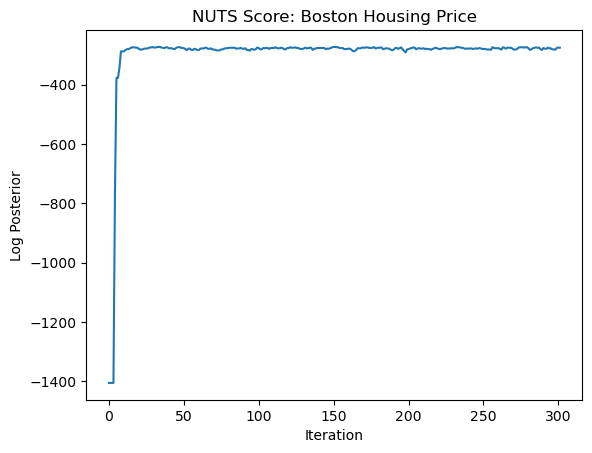

.
[NUTS] sampling complete with final apated ϵ = 0.03703478953320779


In [31]:
#Straight NUTS
Δ_max = 1000
obs_master = choicemap()::ChoiceMap
obs_master[:y] = y_train
obs = obs_master;
(trace,) = generate(interpolator, (x_train,), obs)
#trace = best_trace
#sigma = 1/(trace[:τᵧ]) #Best so far: 3.0483
#println("$sigma")

#Trace 1
param_selection = select()

for i=1:1 #Number of Layers
    push!(param_selection, :W)
    push!(param_selection, :b)
end

m=300

traces = NUTS(trace, param_selection, 0.65, m+1, m, true); #m+1, m=100, 0.65
accs = []

#-----------------------------------
#Plot Log Posterior Scores by Trace
#-----------------------------------

plot([get_score(trace) for trace in traces])
plt.title("NUTS Score: Boston Housing Price")
plt.xlabel("Iteration")
plt.ylabel("Log Posterior");

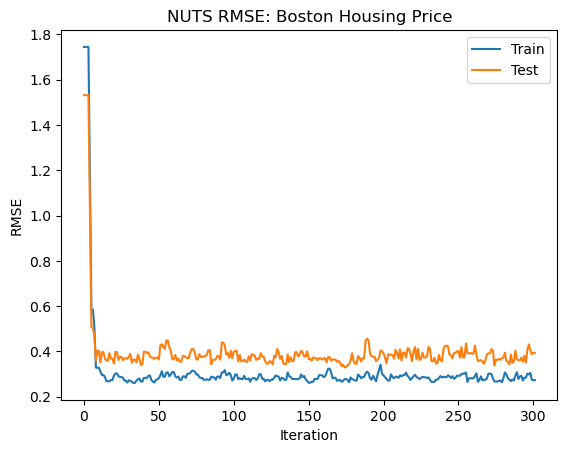

In [32]:
#-------------------------------
#Plot RMSE Train Scores by Trace
#-------------------------------

mses_train = []
for i=1:length(traces)
    trace = traces[i]
    pred_y = transpose(G(x_train,trace))[:,1]
    mse = mse_scaled(pred_y,y_train)

    push!(mses_train,mse)
end

mses_test = []
for i=1:length(traces)
    trace = traces[i]
    pred_y = transpose(G(x_test,trace))[:,1]
    mse = mse_scaled(pred_y,y_test)

    push!(mses_test,mse)
end

plot(mses_train,label="Train")
plot(mses_test, label="Test")
plt.title("NUTS RMSE: Boston Housing Price")
plt.xlabel("Iteration")
plt.ylabel("RMSE");
plt.legend()

best_trace = traces[1]
for i=1:length(traces)
    if get_score(traces[i]) > get_score(best_trace)
        best_trace = traces[i]
    end
end

In [33]:
#----------------
#Marginalize RMSE
#----------------
j = 20
y_marginal = zeros(length(y_train))

for i=j:length(traces)
    trace = traces[i]
    pred_y = transpose(G(x_train,trace))[:,1]
    y_marginal += (pred_y/(length(traces)-j))
end

#display(y_marginal[1:5])
#display(y[1:5])

mse = mse_scaled(y_marginal, y_train)
println("Training Set Marginal RMSE: $mse")

j = 20
y_marginal = zeros(length(y_test))

for i=j:length(traces)
    trace = traces[i]
    pred_y = transpose(G(x_test,trace))[:,1]
    y_marginal += (pred_y/(length(traces)-j))
end

#display(y_marginal[1:5])
#display(y[1:5])

mse = mse_scaled(y_marginal, y_test)
println("Test Set Marginal RMSE: $mse")

Training Set Marginal RMSE: 0.2511431884674917
Test Set Marginal RMSE: 0.35324596346597625


In [24]:
#NUTS with Hyperparam Sampling

Δ_max = 1000
m = 2

#Trace 1
param_selection = select()

for i=1:1 #Number of Layers
    push!(param_selection, :W)
    push!(param_selection, :b)
end

obs_master = choicemap()::ChoiceMap
obs_master[:y] = y_train
obs = obs_master;
(trace,) = generate(interpolator, (x_train,), obs)

traces = []
accs = [] 

for i=1:100
    prev_trace = trace
    trace = NUTS(trace, param_selection, 0.65, m+1, m, false)[m+1];
       
    #hyper_selection = select()
    #push!(hyper_selection, :τᵧ)
    #(trace, _, _) = regenerate(trace, hyper_selection)
    
    u = rand(Uniform(0,1))
    score = get_score(trace) - get_score(prev_trace)
    if log(u) < score
        trace = trace
        if score == 0
            push!(accs,0)
        else
            push!(accs,1)
        end
    else
        trace = prev_trace
        push!(accs,0)
    end
    push!(traces,trace)
    
    if i%10 == 0
        println("Epoch $i Acceptance: $(sum(accs)/length(accs))")
    end
end

Epoch 10 Acceptance: 0.0
Epoch 20 Acceptance: 0.0
Epoch 30 Acceptance: 0.0
Epoch 40 Acceptance: 0.0
Epoch 50 Acceptance: 0.0
Epoch 60 Acceptance: 0.0
Epoch 70 Acceptance: 0.0
Epoch 80 Acceptance: 0.0
Epoch 90 Acceptance: 0.0
Epoch 100 Acceptance: 0.0


In [ ]:
#Bayesian Neural Net (Function)
function G(x, 
        trace, 
        activation=sigmoid
    )
    
    d = length(x[:,1]) #Dimension

    l = trace[:l]
    ks = [trace[(:k,i)] for i=1:layers]
    
    for i=1:l
        in_dim, out_dim = layer_unpacker(i, l, ks, d)
        W = reshape(trace[(:W,i)], out_dim, in_dim)
        b = reshape(trace[(:b,i)], trace[(:k,i)])
        nn = Dense(W, b, activation)
        x = nn(x)
    end
    
    Wₒ = reshape(trace[(:W,l+1)], 1, ks[l])
    bₒ = reshape(trace[(:b,l+1)], 1)
    
    nn_out = Dense(Wₒ, bₒ)
    return nn_out(x)
end;

In [ ]:
#Run Inference